[nltk_data] Downloading package stopwords to C:\Users\Himanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Himanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


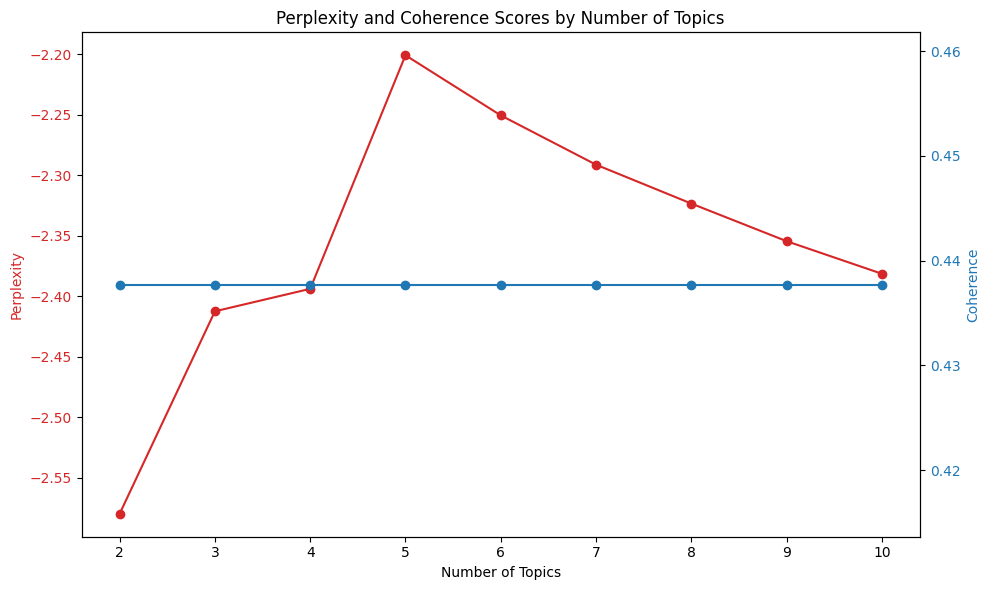

Optimal number of topics: 5
Topic 1: user account unauthorized access detected system occurred center crash data
Topic 2: detected employee theft asset account access user unauthorized due fire
Topic 3: server damage due incident fire detected access unauthorized user account
Topic 4: system occurred crash center data detected access user unauthorized account
Topic 5: detected theft employee asset data crash center occurred system access


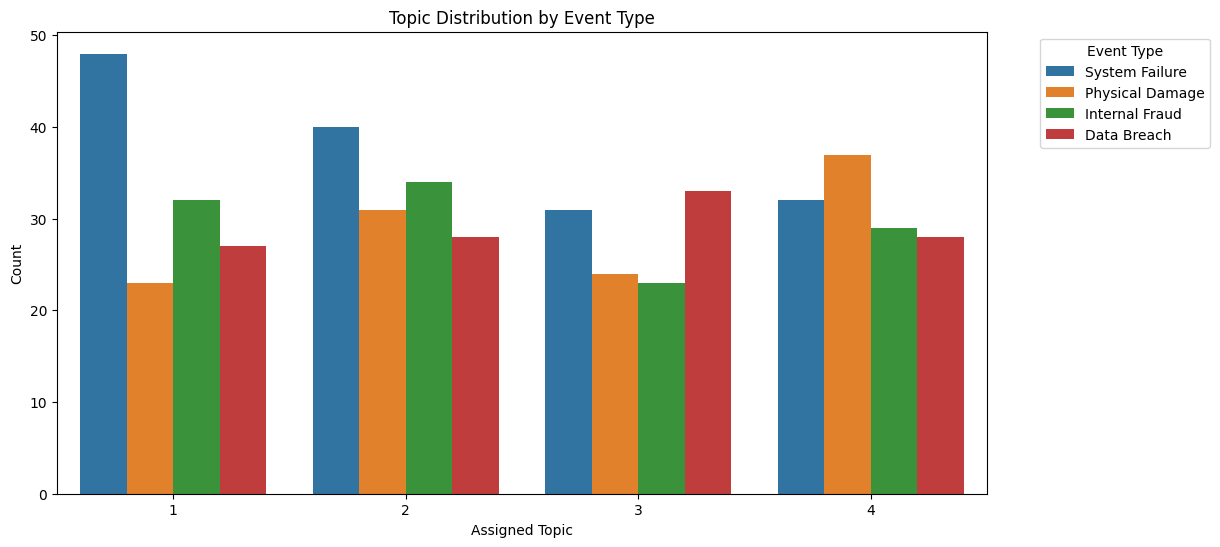

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
import nltk

# Download stopwords
nltk.download('stopwords')
nltk.download('wordnet')

# Sample data generation (dummy dataset)
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
num_records = 500
df = pd.DataFrame({
    'Date': np.random.choice(dates, num_records),
    'EventID': np.arange(1, num_records + 1),
    'EventType': np.random.choice(['System Failure', 'Data Breach', 'Internal Fraud', 'Physical Damage'], num_records),
    'EventDescription': np.random.choice(['System crash occurred in data center', 
                                          'Unauthorized access detected in user accounts', 
                                          'Employee theft of assets detected', 
                                          'Server damage due to fire incident'], num_records),
    'NetLossAmount': np.random.randint(1000, 50000, num_records)
})

# Text preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text.lower())
    text = re.sub(r'\s+', ' ', text)
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df['CleanedDescription'] = df['EventDescription'].apply(preprocess_text)

# Tokenize descriptions for gensim
df['TokenizedDescription'] = df['CleanedDescription'].apply(lambda x: x.split())

# Create dictionary and corpus for gensim
dictionary = corpora.Dictionary(df['TokenizedDescription'])
corpus = [dictionary.doc2bow(text) for text in df['TokenizedDescription']]

# Initialize variables to store coherence and perplexity
topic_range = range(2, 11)
perplexity_values = []
coherence_values = []

# Run LDA and calculate coherence and perplexity for each number of topics
for num_topics in topic_range:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)
    perplexity_values.append(lda_model.log_perplexity(corpus))
    
    coherence_model = CoherenceModel(model=lda_model, texts=df['TokenizedDescription'], dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

# Plotting Perplexity and Coherence
fig, ax1 = plt.subplots(figsize=(10, 6))

# Perplexity plot
color = 'tab:red'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Perplexity', color=color)
ax1.plot(topic_range, perplexity_values, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Perplexity and Coherence Scores by Number of Topics')

# Coherence plot
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Coherence', color=color)
ax2.plot(topic_range, coherence_values, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

# Best LDA model based on coherence
best_num_topics = topic_range[np.argmax(coherence_values)]
print(f'Optimal number of topics: {best_num_topics}')
lda_best = LdaModel(corpus=corpus, id2word=dictionary, num_topics=best_num_topics, random_state=42, passes=10)

# Display the top 10 words for each topic in the best model
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.print_topics(num_words=num_top_words)):
        print(f"Topic {topic_idx + 1}: ", end='')
        print(" ".join([word for word, prob in model.show_topic(topic_idx, topn=num_top_words)]))

display_topics(lda_best, dictionary, 10)

# Assign topics to each event description
topic_distribution = [lda_best.get_document_topics(doc) for doc in corpus]
df['AssignedTopic'] = [max(dist, key=lambda x: x[1])[0] + 1 for dist in topic_distribution]  # Adding 1 to make topic start from 1

# Topic Distribution by Event Type
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='AssignedTopic', hue='EventType')
plt.title('Topic Distribution by Event Type')
plt.xlabel('Assigned Topic')
plt.ylabel('Count')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [2]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data files (if not already downloaded)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to C:\Users\Himanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Himanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Himanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Parameters
num_records = 10000  # Adjust for a large dataset
event_types = ['System Failure', 'Data Breach', 'Theft', 'Fraud', 'Natural Disaster']
event_descriptions = {
    'System Failure': 'A failure in the system caused an outage affecting operations.',
    'Data Breach': 'Sensitive information was accessed by unauthorized individuals.',
    'Theft': 'Company assets were stolen, leading to operational loss.',
    'Fraud': 'Suspicious activities detected involving fraudulent transactions.',
    'Natural Disaster': 'Operations affected due to unforeseen natural events.'
}

# Generate random data
data = []
for i in range(num_records):
    date = datetime.now() - timedelta(days=random.randint(0, 1095))  # Past 3 years
    event_id = f"EID_{i+1:05d}"
    event_type = random.choice(event_types)
    event_description = event_descriptions[event_type]
    net_loss_amount = round(random.uniform(1000, 50000), 2)
    
    data.append([date, event_id, event_type, event_description, net_loss_amount])

# Create DataFrame
df = pd.DataFrame(data, columns=['Date', 'EventID', 'EventType', 'EventDescription', 'NetLossAmount'])
df['Date'] = pd.to_datetime(df['Date'])
print(df.head())


                        Date    EventID       EventType  \
0 2023-06-26 09:54:54.683223  EID_00001           Theft   
1 2022-06-07 09:54:54.683223  EID_00002  System Failure   
2 2022-07-27 09:54:54.683223  EID_00003     Data Breach   
3 2023-08-10 09:54:54.683223  EID_00004           Theft   
4 2024-03-12 09:54:54.683223  EID_00005           Theft   

                                    EventDescription  NetLossAmount  
0  Company assets were stolen, leading to operati...       38074.82  
1  A failure in the system caused an outage affec...       13685.34  
2  Sensitive information was accessed by unauthor...       43951.34  
3  Company assets were stolen, leading to operati...       46938.73  
4  Company assets were stolen, leading to operati...       20902.55  


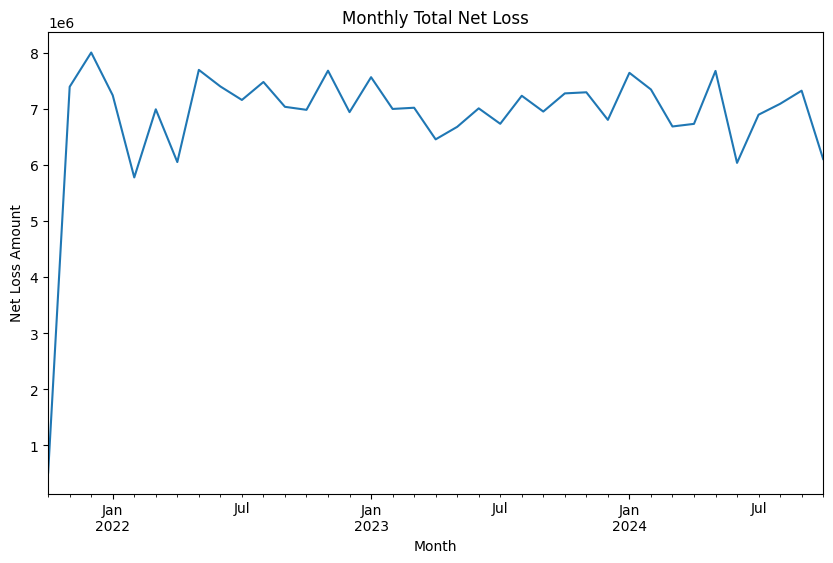

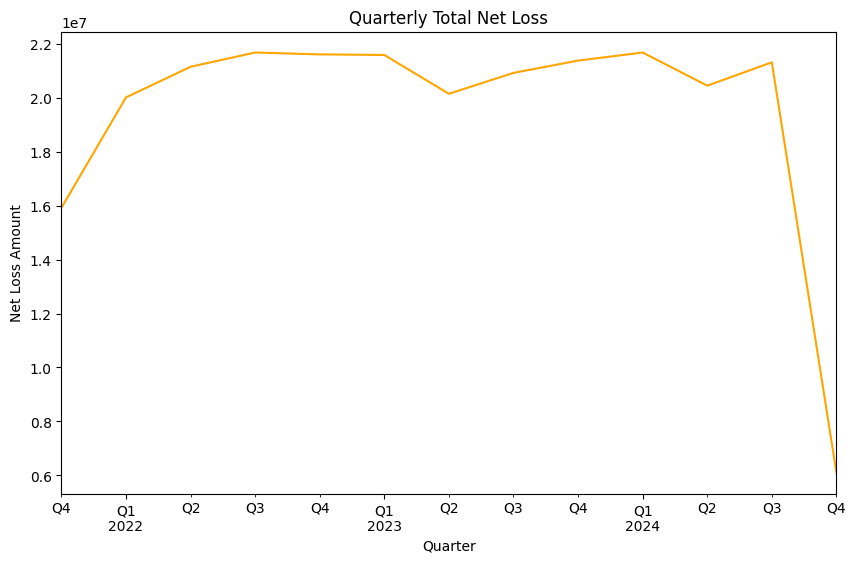

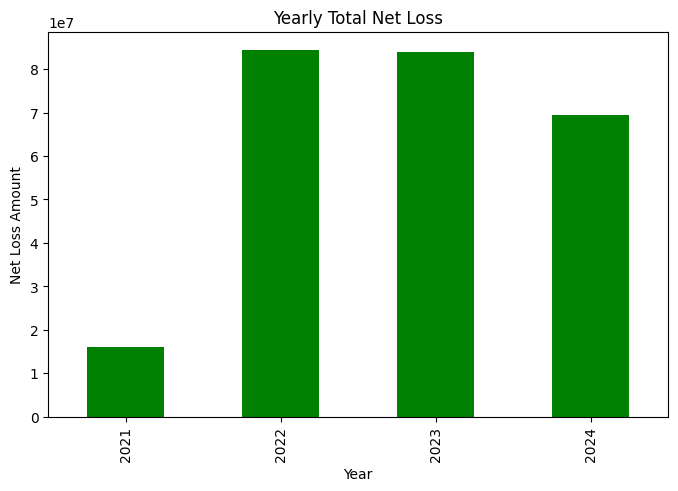

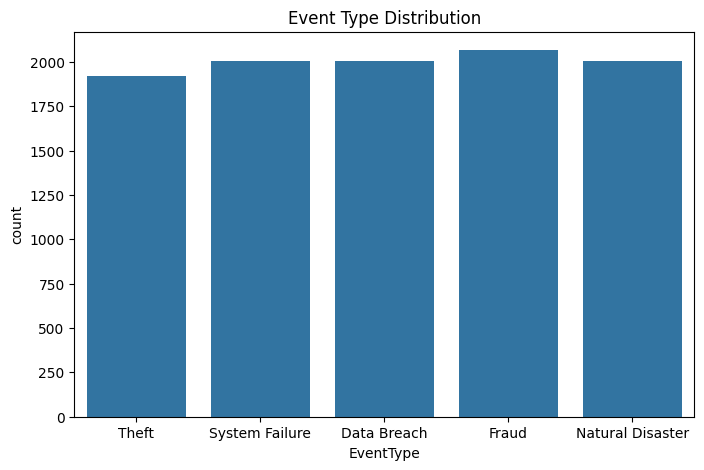

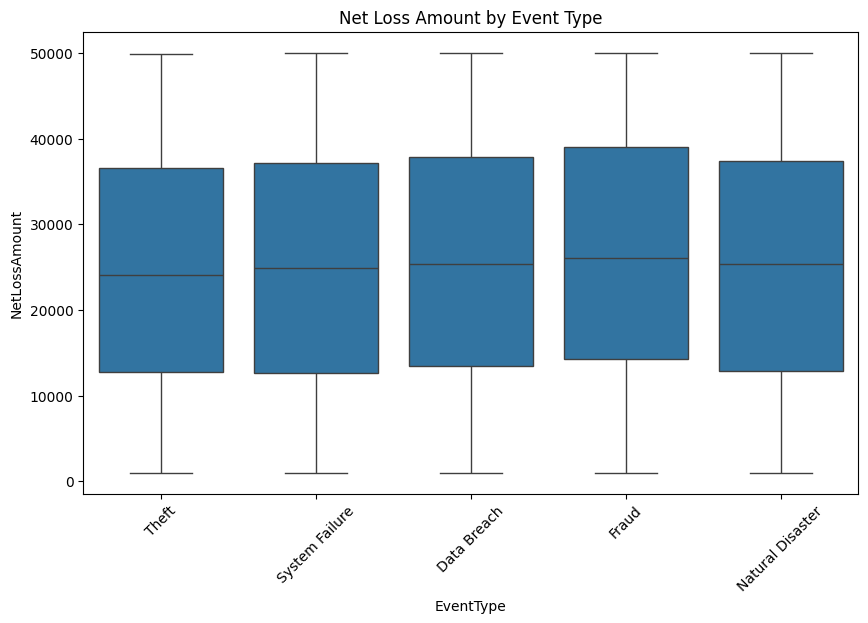

In [4]:
# Convert Date to Year, Month, and Quarter
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.to_period('M')
df['Quarter'] = df['Date'].dt.to_period('Q')

# Monthly Analysis
monthly_data = df.groupby('Month')['NetLossAmount'].sum()
plt.figure(figsize=(10, 6))
monthly_data.plot(kind='line', title='Monthly Total Net Loss')
plt.ylabel('Net Loss Amount')
plt.show()

# Quarterly Analysis
quarterly_data = df.groupby('Quarter')['NetLossAmount'].sum()
plt.figure(figsize=(10, 6))
quarterly_data.plot(kind='line', color='orange', title='Quarterly Total Net Loss')
plt.ylabel('Net Loss Amount')
plt.show()

# Yearly Analysis
yearly_data = df.groupby('Year')['NetLossAmount'].sum()
plt.figure(figsize=(8, 5))
yearly_data.plot(kind='bar', color='green', title='Yearly Total Net Loss')
plt.ylabel('Net Loss Amount')
plt.show()

# Distribution of Event Types
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='EventType')
plt.title('Event Type Distribution')
plt.show()

# Boxplot for Net Loss Amount by Event Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='EventType', y='NetLossAmount')
plt.title('Net Loss Amount by Event Type')
plt.xticks(rotation=45)
plt.show()


In [5]:
# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

df['CleanedDescription'] = df['EventDescription'].apply(preprocess_text)
print(df[['EventDescription', 'CleanedDescription']].head())


                                    EventDescription  \
0  Company assets were stolen, leading to operati...   
1  A failure in the system caused an outage affec...   
2  Sensitive information was accessed by unauthor...   
3  Company assets were stolen, leading to operati...   
4  Company assets were stolen, leading to operati...   

                                  CleanedDescription  
0      company asset stolen leading operational loss  
1   failure system caused outage affecting operation  
2  sensitive information accessed unauthorized in...  
3      company asset stolen leading operational loss  
4      company asset stolen leading operational loss  


In [6]:
# Vectorize the cleaned descriptions
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['CleanedDescription'])

# Check similarity within descriptions and event types
event_type_descriptions = [preprocess_text(desc) for desc in event_descriptions.values()]
event_type_matrix = tfidf_vectorizer.transform(event_type_descriptions)
similarities = cosine_similarity(tfidf_matrix, event_type_matrix)

# Assign the best-matched event type based on similarity
df['PredictedEventType'] = [event_types[np.argmax(sim)] for sim in similarities]

# Accuracy of prediction
accuracy = (df['EventType'] == df['PredictedEventType']).mean()
print(f"Description matching accuracy with Event Type: {accuracy:.2%}")


Description matching accuracy with Event Type: 100.00%


In [7]:
# Extract Year, Month, and Quarter from Date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter


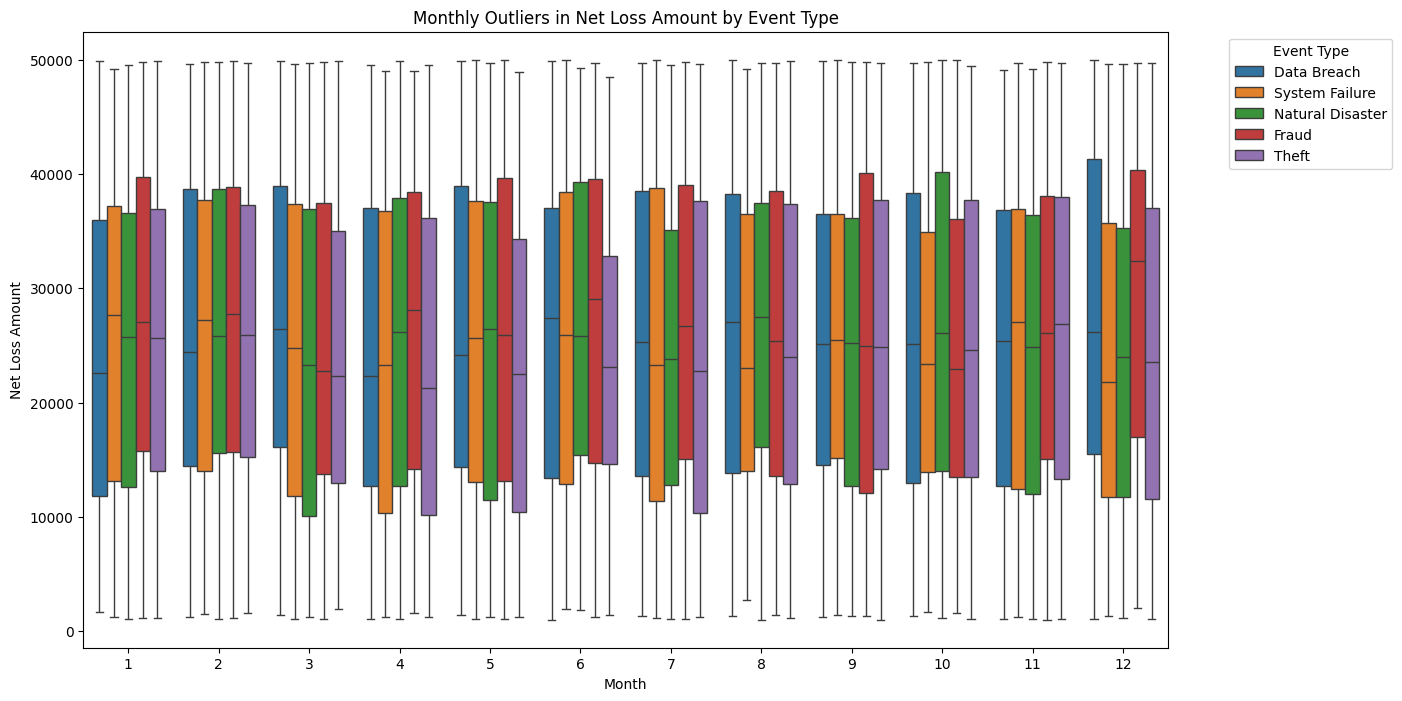

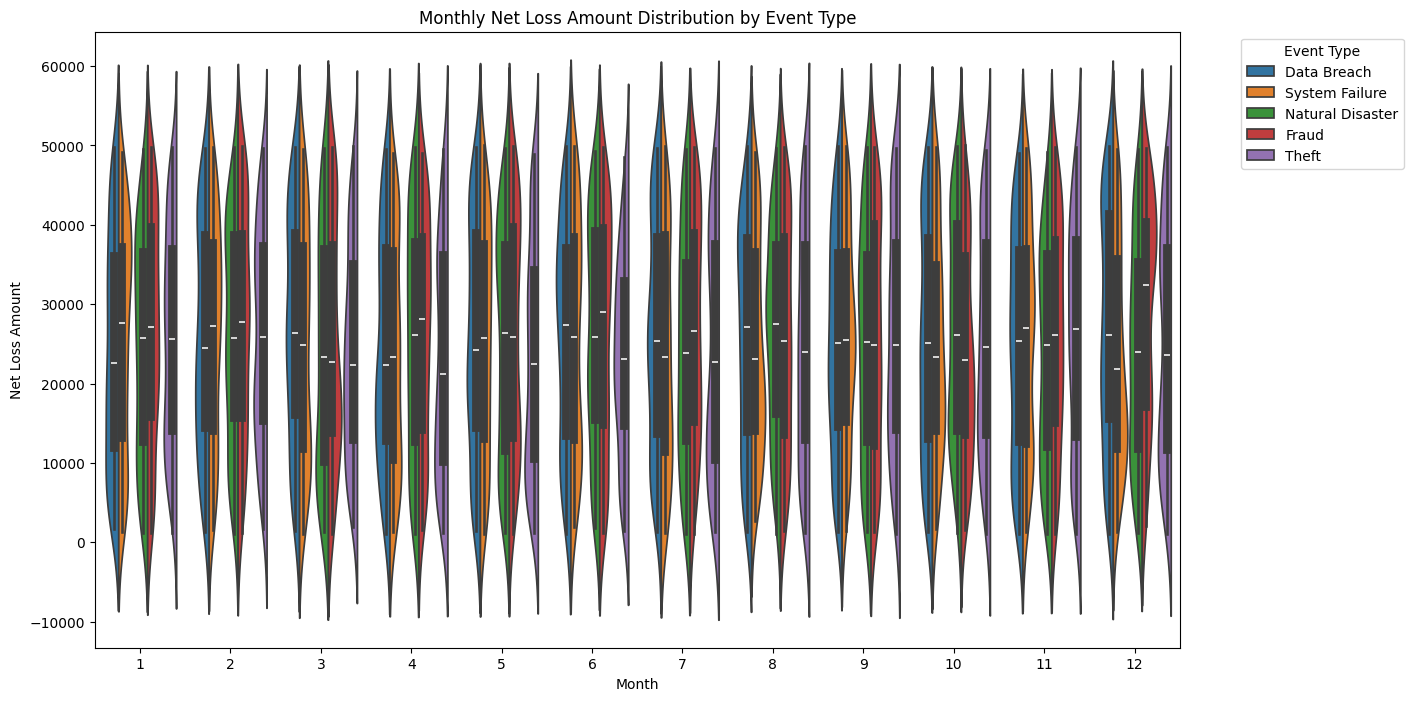

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Monthly Outliers by Event Type
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='Month', y='NetLossAmount', hue='EventType')
plt.title('Monthly Outliers in Net Loss Amount by Event Type')
plt.ylabel('Net Loss Amount')
plt.xlabel('Month')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Violin Plot for Monthly Distribution
plt.figure(figsize=(14, 8))
sns.violinplot(data=df, x='Month', y='NetLossAmount', hue='EventType', split=True)
plt.title('Monthly Net Loss Amount Distribution by Event Type')
plt.ylabel('Net Loss Amount')
plt.xlabel('Month')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


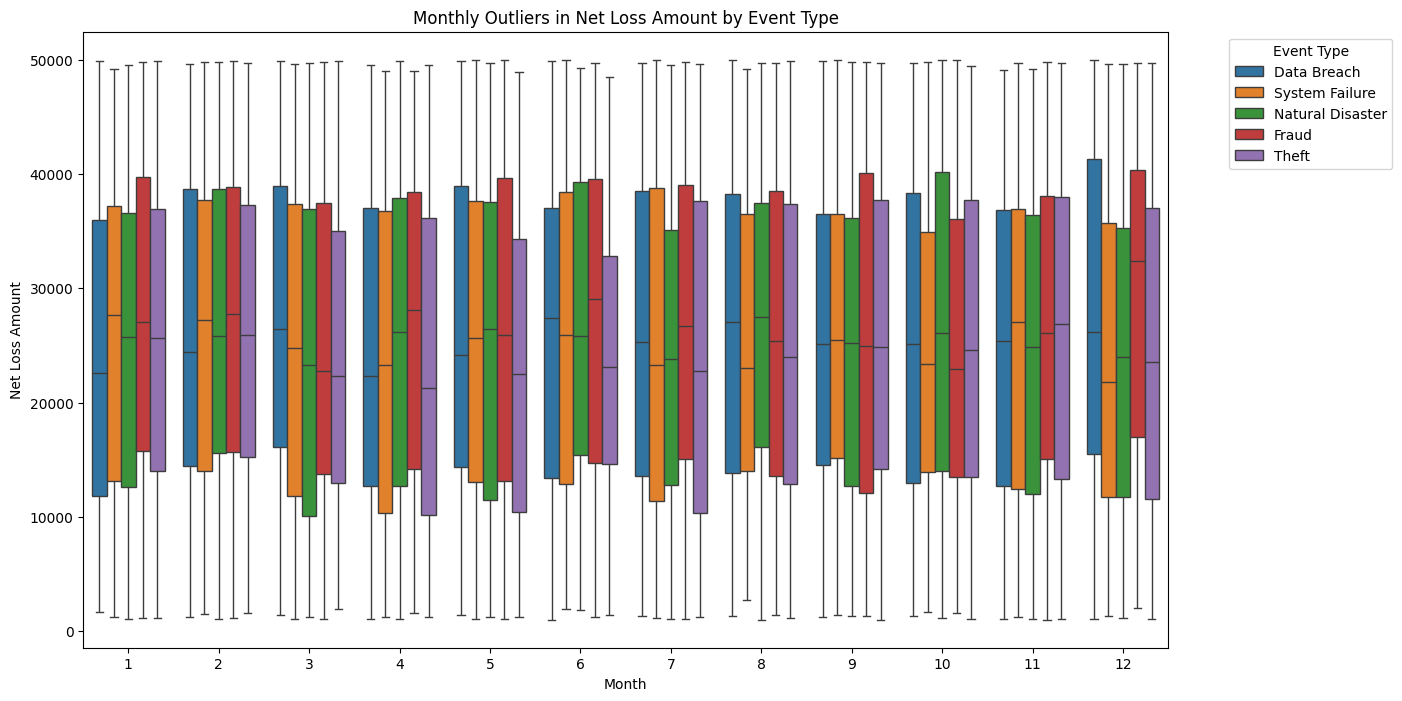

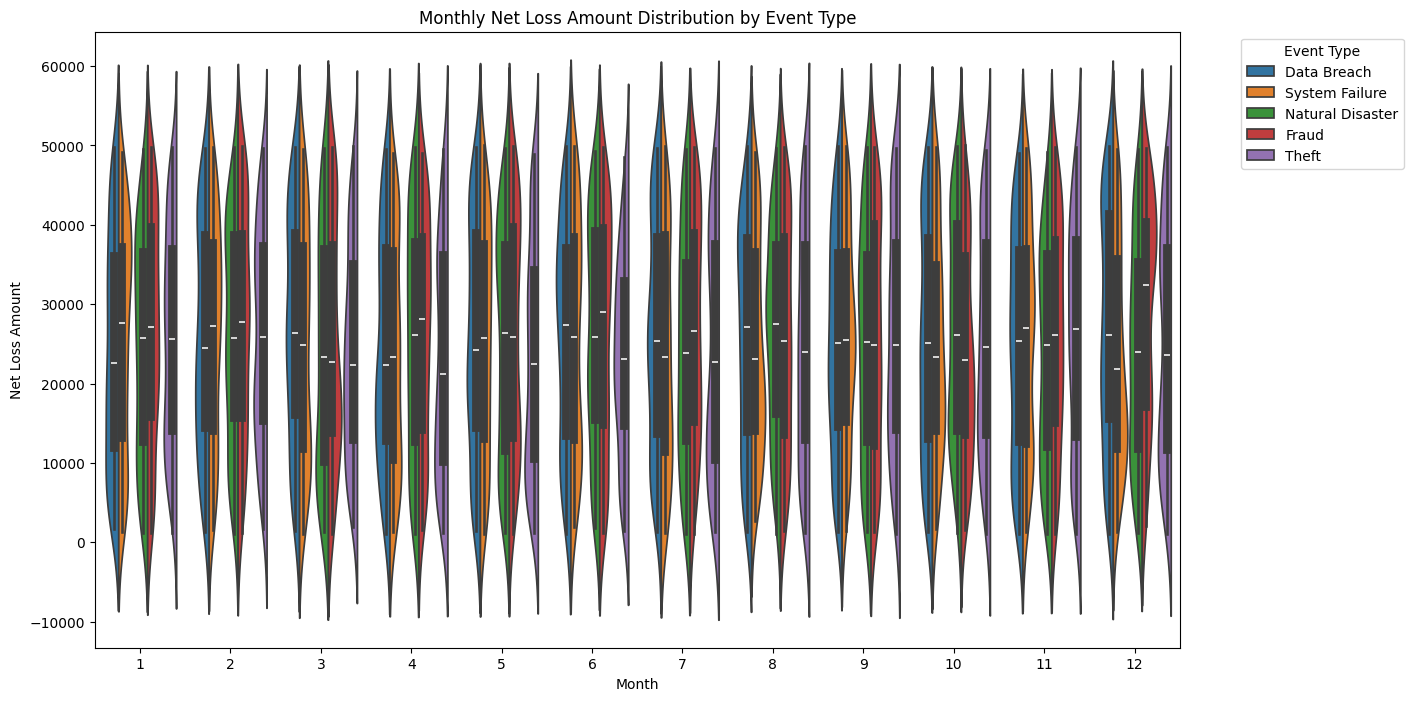

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Monthly Outliers by Event Type
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='Month', y='NetLossAmount', hue='EventType')
plt.title('Monthly Outliers in Net Loss Amount by Event Type')
plt.ylabel('Net Loss Amount')
plt.xlabel('Month')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Violin Plot for Monthly Distribution
plt.figure(figsize=(14, 8))
sns.violinplot(data=df, x='Month', y='NetLossAmount', hue='EventType', split=True)
plt.title('Monthly Net Loss Amount Distribution by Event Type')
plt.ylabel('Net Loss Amount')
plt.xlabel('Month')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


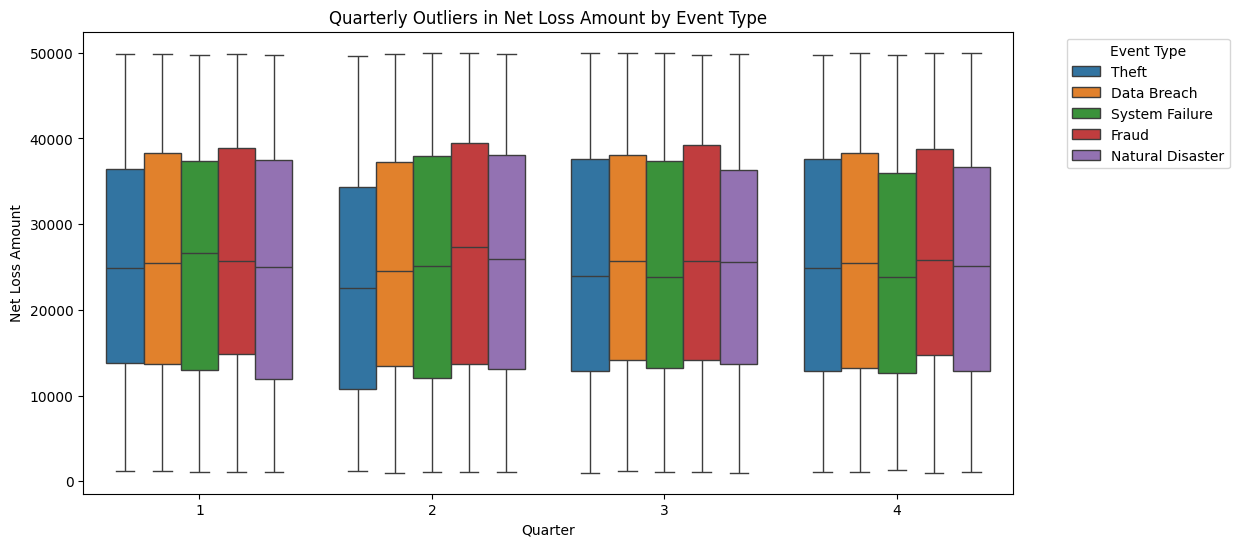

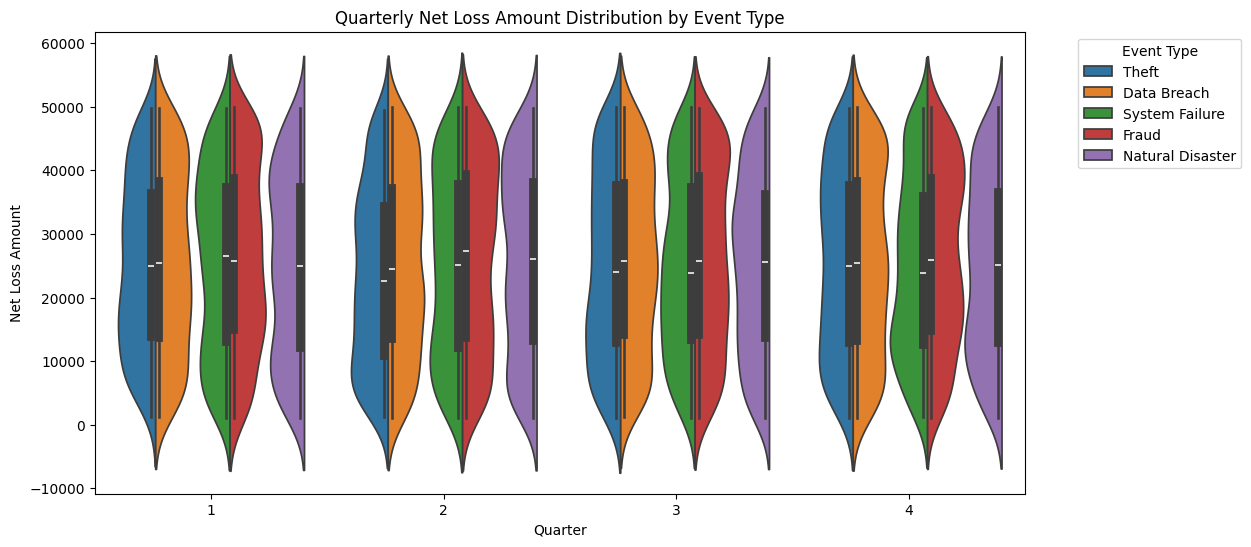

In [10]:
# Quarterly Outliers by Event Type
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Quarter', y='NetLossAmount', hue='EventType')
plt.title('Quarterly Outliers in Net Loss Amount by Event Type')
plt.ylabel('Net Loss Amount')
plt.xlabel('Quarter')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Violin Plot for Quarterly Distribution
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='Quarter', y='NetLossAmount', hue='EventType', split=True)
plt.title('Quarterly Net Loss Amount Distribution by Event Type')
plt.ylabel('Net Loss Amount')
plt.xlabel('Quarter')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


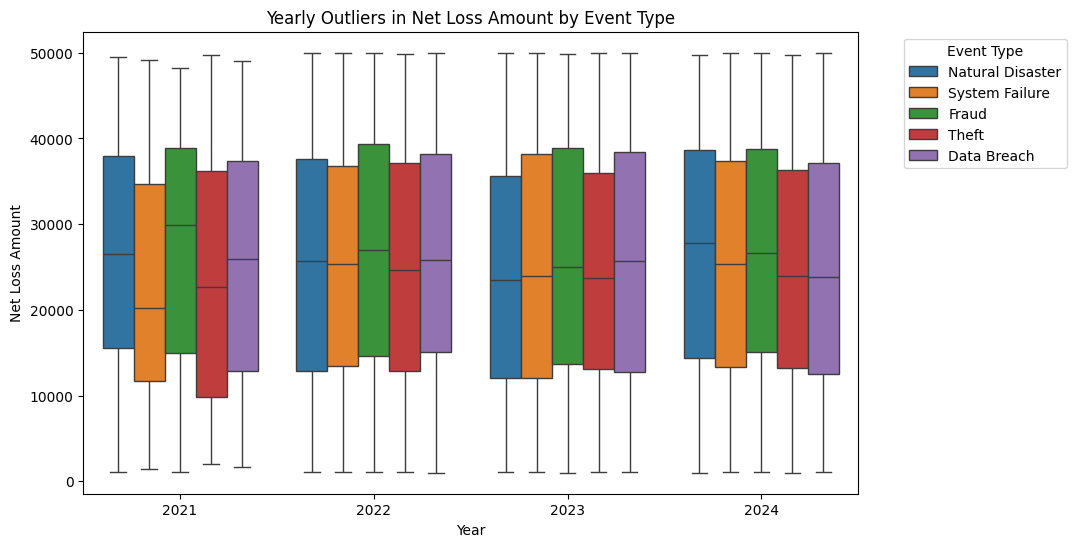

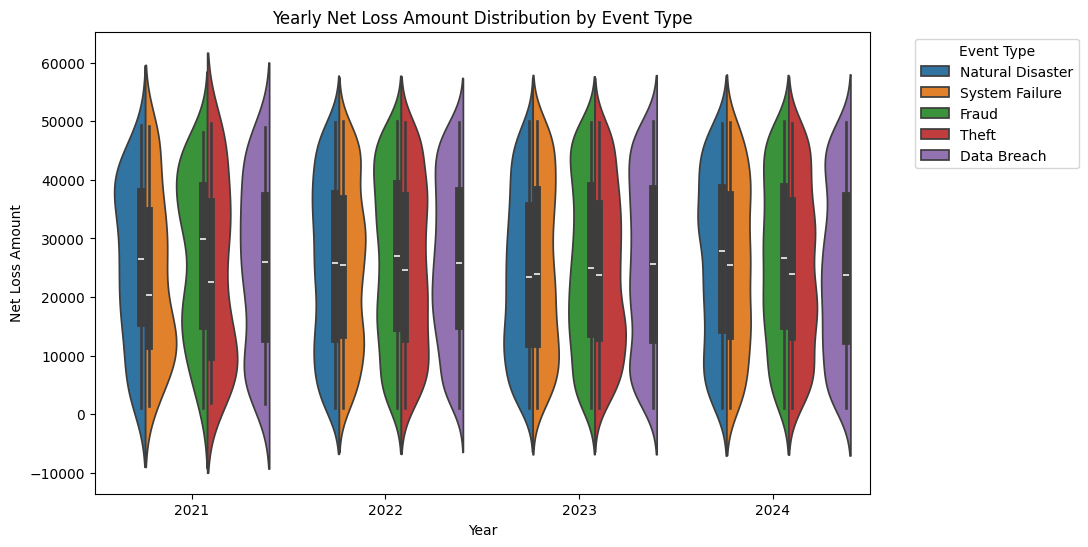

In [11]:
# Yearly Outliers by Event Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Year', y='NetLossAmount', hue='EventType')
plt.title('Yearly Outliers in Net Loss Amount by Event Type')
plt.ylabel('Net Loss Amount')
plt.xlabel('Year')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Violin Plot for Yearly Distribution
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Year', y='NetLossAmount', hue='EventType', split=True)
plt.title('Yearly Net Loss Amount Distribution by Event Type')
plt.ylabel('Net Loss Amount')
plt.xlabel('Year')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download stopwords if not already done
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Lemmatizer and Stop Words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text Preprocessing
def preprocess_text(text):
    # Lowercase and remove punctuation
    text = re.sub(r'\W', ' ', text.lower())
    text = re.sub(r'\s+', ' ', text)
    # Tokenize, remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df['CleanedDescription'] = df['EventDescription'].apply(preprocess_text)
print(df[['EventDescription', 'CleanedDescription']].head())


[nltk_data] Downloading package stopwords to C:\Users\Himanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Himanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                    EventDescription  \
0  Company assets were stolen, leading to operati...   
1  A failure in the system caused an outage affec...   
2  Sensitive information was accessed by unauthor...   
3  Company assets were stolen, leading to operati...   
4  Company assets were stolen, leading to operati...   

                                  CleanedDescription  
0      company asset stolen leading operational loss  
1   failure system caused outage affecting operation  
2  sensitive information accessed unauthorized in...  
3      company asset stolen leading operational loss  
4      company asset stolen leading operational loss  


In [13]:
# Using TF-IDF Vectorizer for LDA
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['CleanedDescription'])


In [14]:
# Define the number of topics
num_topics = 5

# Initialize LDA model
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(tfidf_matrix)

# Display the topics with the top words
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}: ", end='')
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Display the top 10 words for each topic
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(lda_model, tfidf_feature_names, 10)


Topic 1: unauthorized sensitive accessed individual information operation fraudulent transaction activity detected
Topic 2: outage affecting caused failure operation unforeseen affected natural event fraudulent
Topic 3: fraudulent transaction activity involving detected suspicious operation unforeseen affected natural
Topic 4: stolen loss leading operational asset company operation fraudulent transaction suspicious
Topic 5: unforeseen affected natural event operation outage affecting caused failure fraudulent


In [15]:
# Get topic distribution for each description
topic_distribution = lda_model.transform(tfidf_matrix)

# Assign the most probable topic to each event description
df['AssignedTopic'] = topic_distribution.argmax(axis=1) + 1  # Topic index starts from 0, so add 1 for readability
print(df[['EventDescription', 'AssignedTopic']].head())


                                    EventDescription  AssignedTopic
0  Company assets were stolen, leading to operati...              4
1  A failure in the system caused an outage affec...              2
2  Sensitive information was accessed by unauthor...              1
3  Company assets were stolen, leading to operati...              4
4  Company assets were stolen, leading to operati...              4


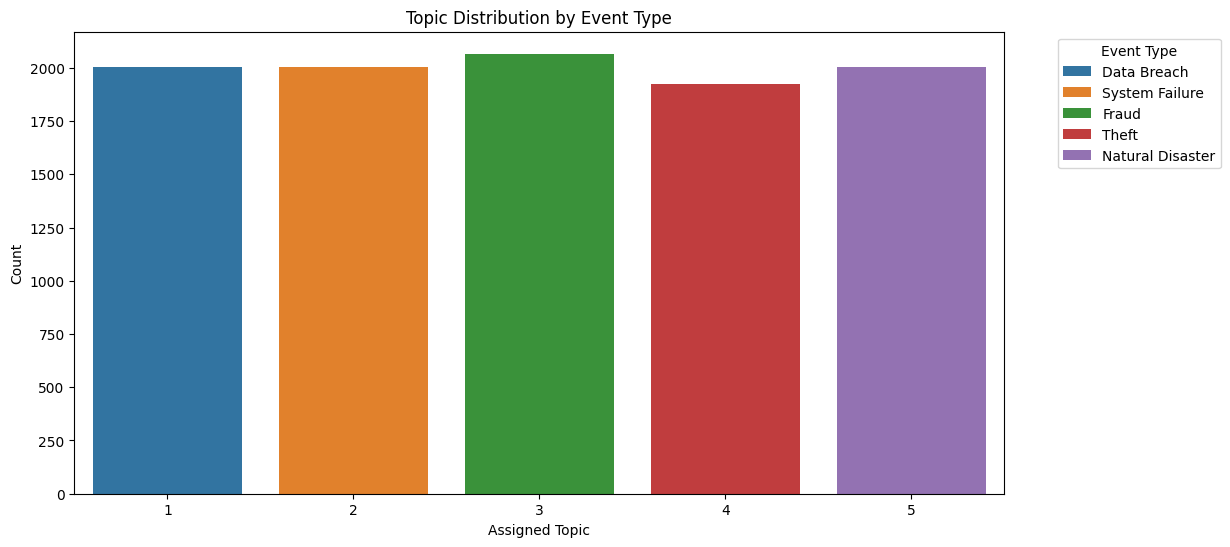

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Topic Distribution by Event Type
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='AssignedTopic', hue='EventType')
plt.title('Topic Distribution by Event Type')
plt.xlabel('Assigned Topic')
plt.ylabel('Count')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


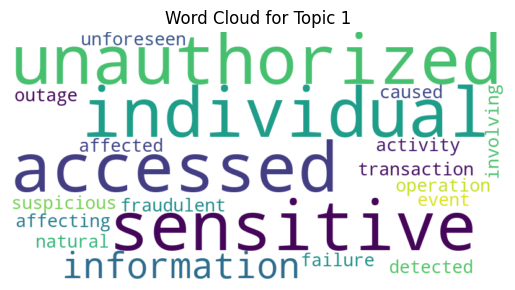

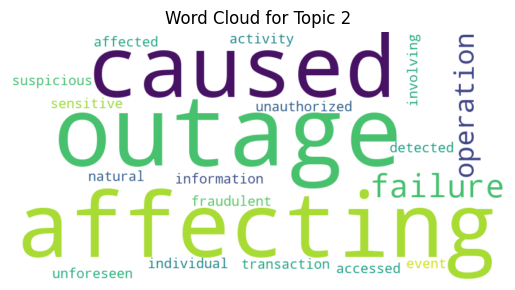

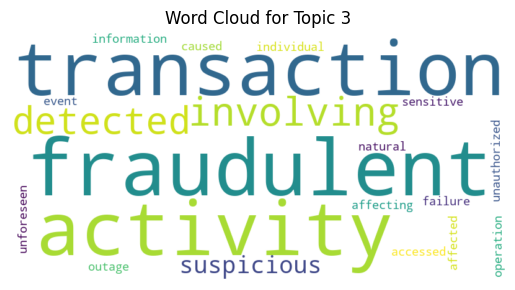

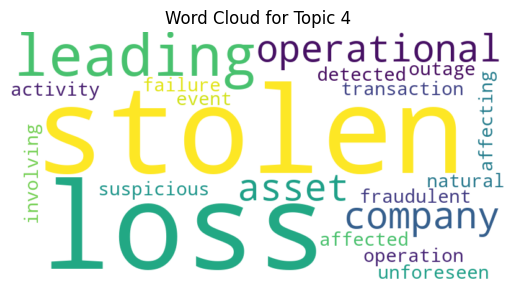

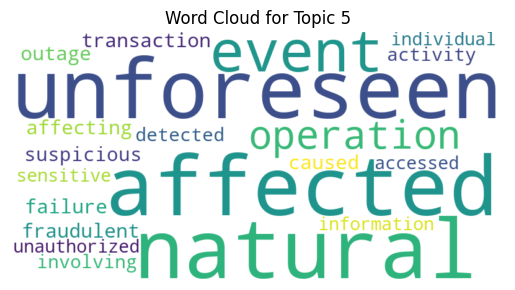

In [17]:
from wordcloud import WordCloud

# Generate word clouds for each topic
for topic_idx, topic in enumerate(lda_model.components_):
    plt.figure()
    wordcloud = WordCloud(width=800, height=400, max_words=20, background_color='white')
    topic_words = {tfidf_feature_names[i]: topic[i] for i in topic.argsort()[:-21:-1]}
    wordcloud.generate_from_frequencies(topic_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_idx + 1}")
    plt.show()


[nltk_data] Downloading package stopwords to C:\Users\Himanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Himanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_13676\2221251576.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_loss = df.resample('M')['NetLossAmount'].sum()


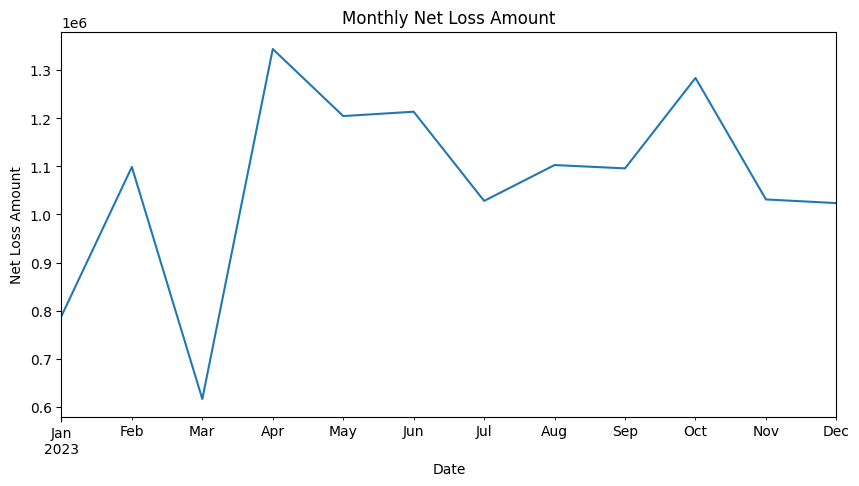

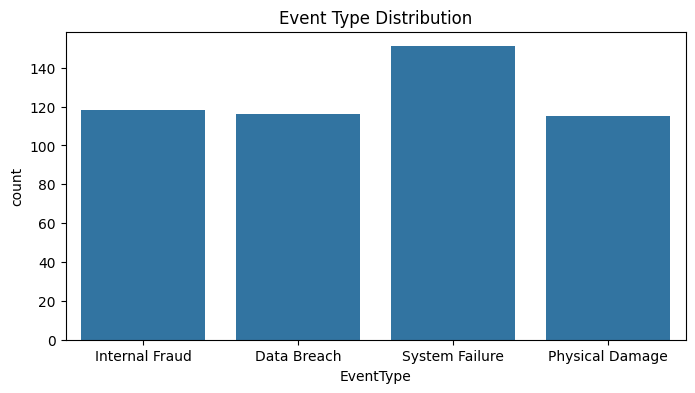

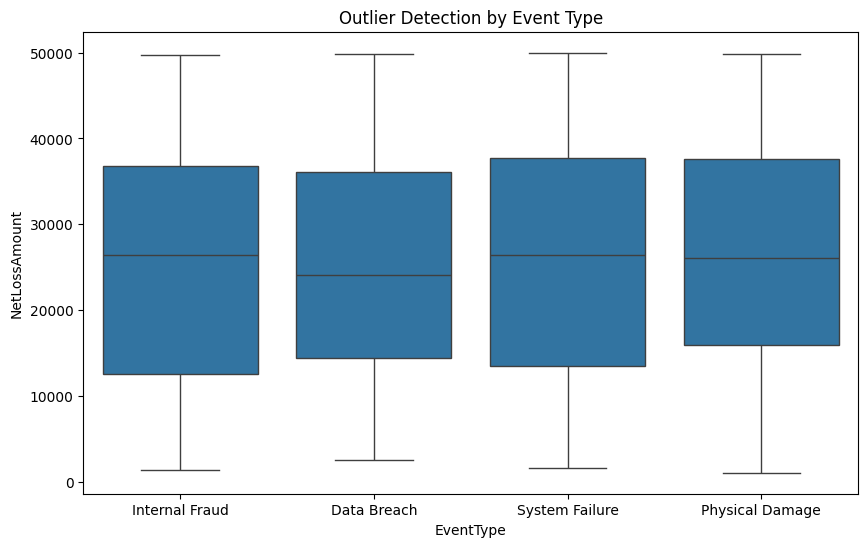

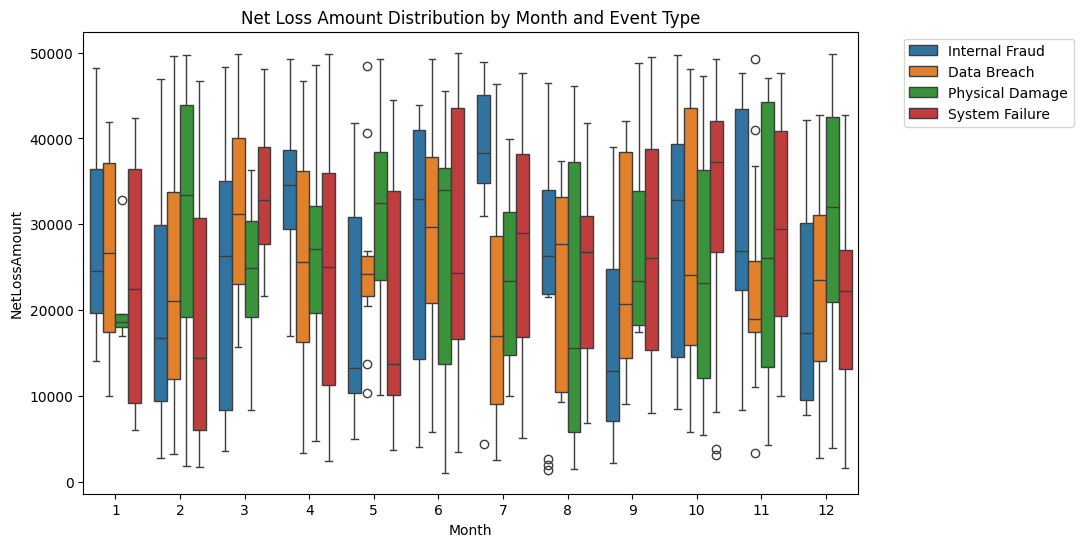

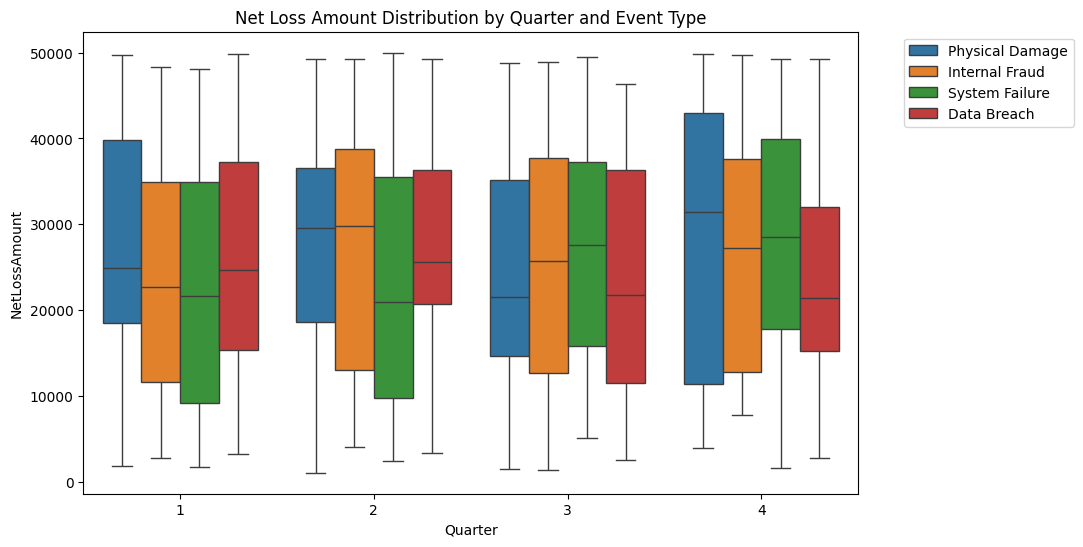

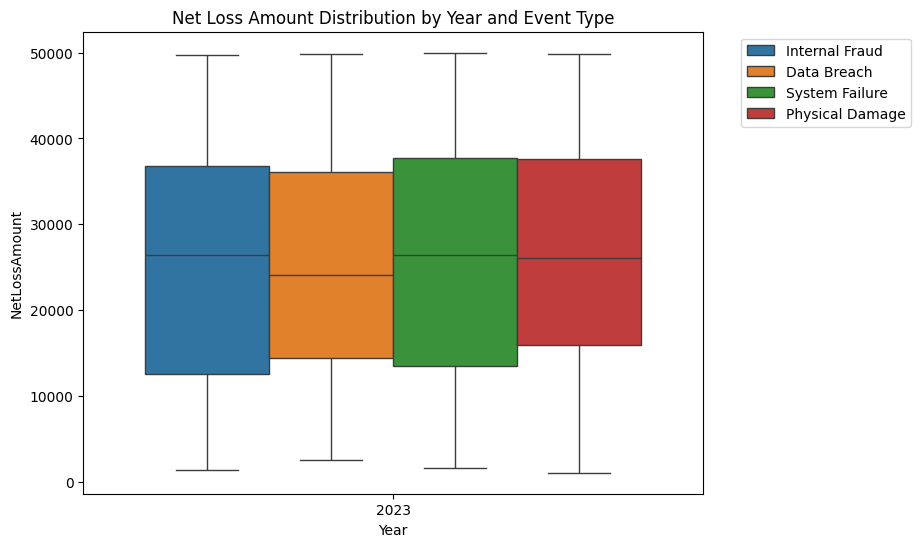

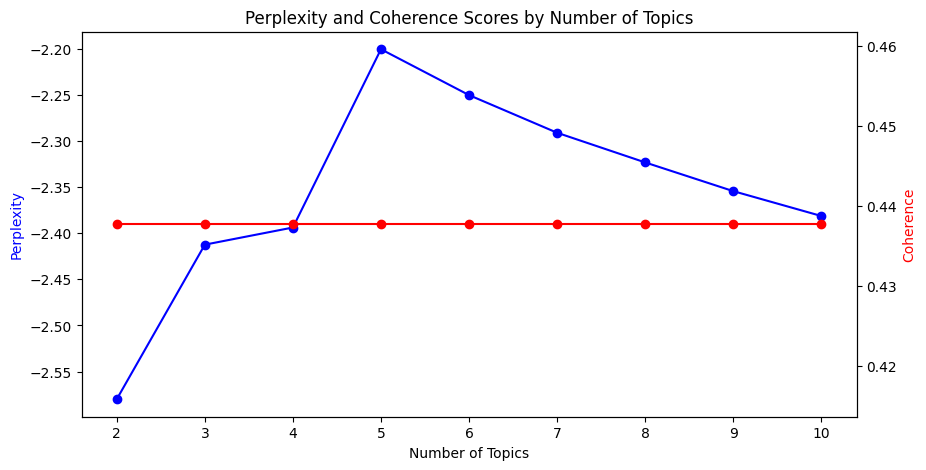

Assigned Topics:
                                          EventDescription  AssignedTopic
Date                                                                    
2023-04-13           System crash occurred in data center              4
2023-12-15             Server damage due to fire incident              3
2023-09-28  Unauthorized access detected in user accounts              1
2023-04-17  Unauthorized access detected in user accounts              1
2023-03-13  Unauthorized access detected in user accounts              1


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_13676\2221251576.py:137: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.resample('M')['NetLossAmount'].sum()


ValueError: x must have 2 complete cycles requires 24 observations. x only has 12 observation(s)

In [18]:
# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from pmdarima import auto_arima

# Download NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')

# Generate sample data
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
num_records = 500
df = pd.DataFrame({
    'Date': np.random.choice(dates, num_records),
    'EventID': np.arange(1, num_records + 1),
    'EventType': np.random.choice(['System Failure', 'Data Breach', 'Internal Fraud', 'Physical Damage'], num_records),
    'EventDescription': np.random.choice(['System crash occurred in data center', 
                                          'Unauthorized access detected in user accounts', 
                                          'Employee theft of assets detected', 
                                          'Server damage due to fire incident'], num_records),
    'NetLossAmount': np.random.randint(1000, 50000, num_records)
})

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

### Step 1: EDA on Event Types and Loss Amounts
# Monthly Aggregation
monthly_loss = df.resample('M')['NetLossAmount'].sum()

# Plot Monthly Loss
plt.figure(figsize=(10, 5))
monthly_loss.plot(title="Monthly Net Loss Amount")
plt.ylabel("Net Loss Amount")
plt.show()

# Distribution of Event Types
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='EventType')
plt.title('Event Type Distribution')
plt.show()

# Outlier Detection by Event Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='EventType', y='NetLossAmount')
plt.title('Outlier Detection by Event Type')
plt.show()

# Aggregations by Month, Quarter, and Year
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year

# Boxplot for Amount Distribution by Month
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Month', y='NetLossAmount', hue='EventType')
plt.title('Net Loss Amount Distribution by Month and Event Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Boxplot for Amount Distribution by Quarter
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Quarter', y='NetLossAmount', hue='EventType')
plt.title('Net Loss Amount Distribution by Quarter and Event Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Boxplot for Amount Distribution by Year
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Year', y='NetLossAmount', hue='EventType')
plt.title('Net Loss Amount Distribution by Year and Event Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Step 2: NLP Topic Modeling on EventDescription
# Text Preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df['CleanedDescription'] = df['EventDescription'].apply(preprocess_text)
df['TokenizedDescription'] = df['CleanedDescription'].apply(lambda x: x.split())

# Gensim Dictionary and Corpus Creation
dictionary = corpora.Dictionary(df['TokenizedDescription'])
corpus = [dictionary.doc2bow(text) for text in df['TokenizedDescription']]

# Topic Modeling with LDA
topic_range = range(2, 11)
perplexity_values = []
coherence_values = []

for num_topics in topic_range:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)
    perplexity_values.append(lda_model.log_perplexity(corpus))
    coherence_model = CoherenceModel(model=lda_model, texts=df['TokenizedDescription'], dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

# Plot Perplexity and Coherence
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(topic_range, perplexity_values, 'b-', marker='o', label='Perplexity')
ax2 = ax1.twinx()
ax2.plot(topic_range, coherence_values, 'r-', marker='o', label='Coherence')
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Perplexity', color='b')
ax2.set_ylabel('Coherence', color='r')
plt.title('Perplexity and Coherence Scores by Number of Topics')
plt.show()

# Assign topics based on optimal number of topics
best_num_topics = topic_range[np.argmax(coherence_values)]
lda_best = LdaModel(corpus=corpus, id2word=dictionary, num_topics=best_num_topics, random_state=42, passes=10)
df['AssignedTopic'] = [max(dist, key=lambda x: x[1])[0] + 1 for dist in lda_best.get_document_topics(corpus)]
print("Assigned Topics:\n", df[['EventDescription', 'AssignedTopic']].head())

### Step 3: Time Series Analysis and Prediction
# Monthly aggregation for time series analysis
monthly_data = df.resample('M')['NetLossAmount'].sum()

# Decomposition of Time Series
decomposition = seasonal_decompose(monthly_data, model='additive')
decomposition.plot()
plt.show()

# ARIMA Model
arima_model = auto_arima(monthly_data, seasonal=False, trace=True)
arima_order = arima_model.order
arima_fitted = ARIMA(monthly_data, order=arima_order).fit()
print(arima_fitted.summary())

# Forecast with ARIMA
arima_forecast = arima_fitted.forecast(steps=12)
plt.figure(figsize=(10, 5))
plt.plot(monthly_data, label='Historical Data')
plt.plot(arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

# SARIMA Model
sarima_model = auto_arima(monthly_data, seasonal=True, m=12, trace=True)
sarima_order = sarima_model.order
sarima_seasonal_order = sarima_model.seasonal_order
sarima_fitted = SARIMAX(monthly_data, order=sarima_order, seasonal_order=sarima_seasonal_order).fit()
print(sarima_fitted.summary())

# Forecast with SARIMA
sarima_forecast = sarima_fitted.forecast(steps=12)
plt.figure(figsize=(10, 5))
plt.plot(monthly_data, label='Historical Data')
plt.plot(sarima_forecast, label='SARIMA Forecast', linestyle='--')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

# SARIMAX Model: Including Event Type Count as Exogenous Variable
monthly_event_counts = df.groupby([df.index.to_period("M"), 'EventType']).size().unstack(fill_value=0)
sarimax_model = SARIMAX(monthly_data, order=sarima_order, seasonal_order=sarima_seasonal_order, exog=monthly_event_counts).fit()

# Forecast with SARIMAX
sarimax_forecast = sarimax_model.get_forecast(steps=12, exog=monthly_event_counts[-12:]).predicted_mean
plt.figure(figsize=(10, 5))
plt.plot(monthly_data, label='Historical Data')
plt.plot(sarimax_forecast, label='SARIMAX Forecast', linestyle='--')
plt.title('SARIMAX Forecast')
plt.legend()
plt.show()


[nltk_data] Downloading package stopwords to C:\Users\Himanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Himanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


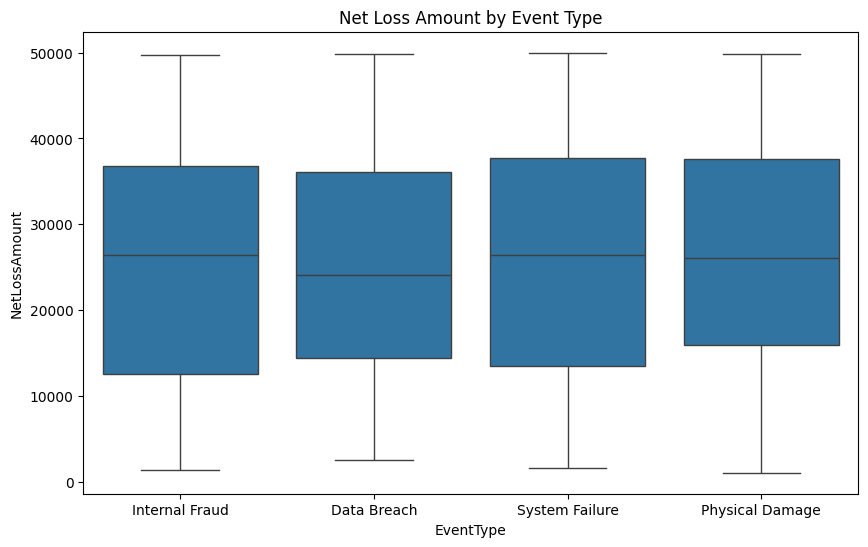

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_13676\4088790120.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_loss = df.resample('M')['NetLossAmount'].sum()


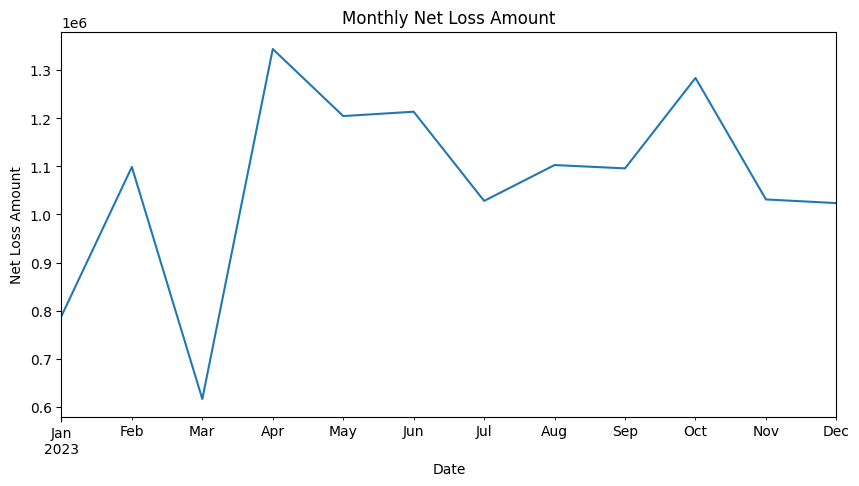

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_13676\4088790120.py:60: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_loss = df.resample('Q')['NetLossAmount'].sum()


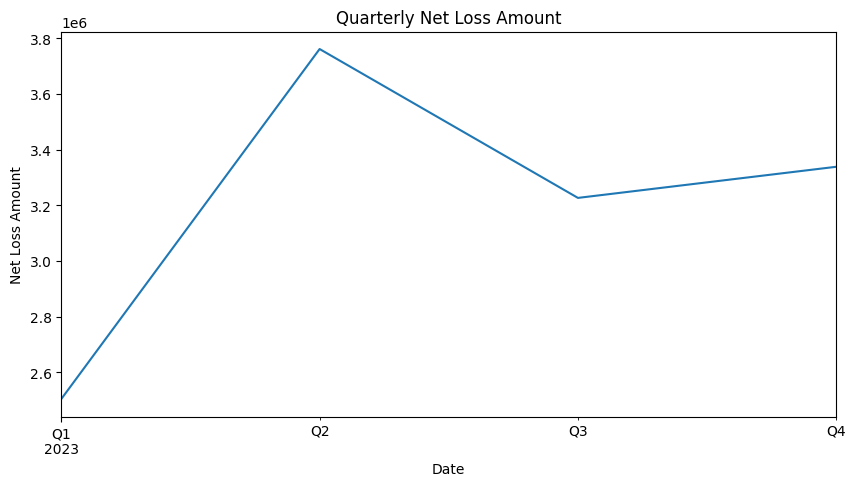

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_13676\4088790120.py:67: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_loss = df.resample('Y')['NetLossAmount'].sum()
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


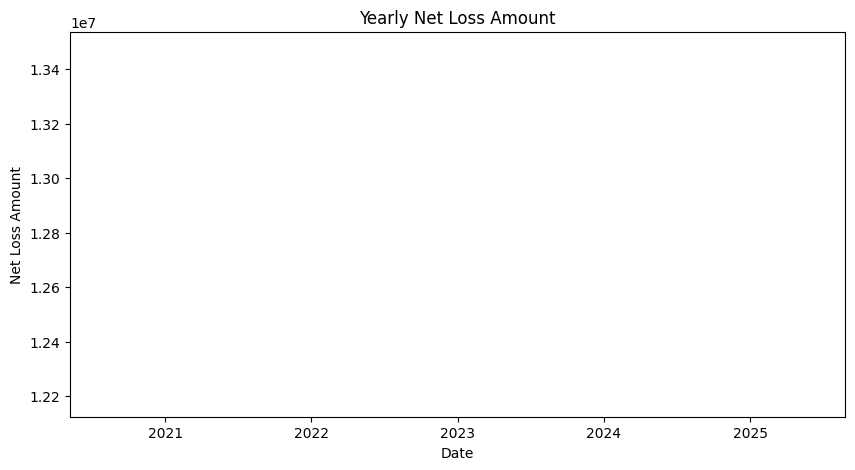


Topics in Event Descriptions:
Topic 1:
data center crash damage server
Topic 2:
theft asset employee detected access


ValueError: could not broadcast input array from shape (12,) into shape (21,)

<Figure size 1000x400 with 0 Axes>

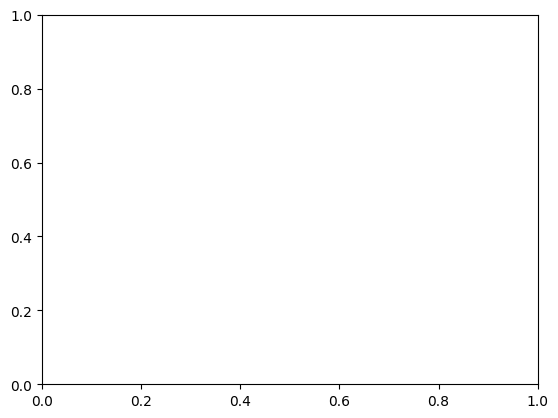

In [19]:
# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')

# Generate sample data
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
num_records = 500
df = pd.DataFrame({
    'Date': np.random.choice(dates, num_records),
    'EventID': np.arange(1, num_records + 1),
    'EventType': np.random.choice(['System Failure', 'Data Breach', 'Internal Fraud', 'Physical Damage'], num_records),
    'EventDescription': np.random.choice(['System crash in data center', 
                                          'Unauthorized access detected', 
                                          'Employee theft of assets', 
                                          'Server damage due to fire'], num_records),
    'NetLossAmount': np.random.randint(1000, 50000, num_records)
})

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Add Time Period columns
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year

# EDA: Outliers & Distribution of NetLossAmount by EventType
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='EventType', y='NetLossAmount')
plt.title('Net Loss Amount by Event Type')
plt.show()

# Monthly Aggregation
monthly_loss = df.resample('M')['NetLossAmount'].sum()
plt.figure(figsize=(10, 5))
monthly_loss.plot(title="Monthly Net Loss Amount")
plt.ylabel("Net Loss Amount")
plt.show()

# Quarterly Aggregation
quarterly_loss = df.resample('Q')['NetLossAmount'].sum()
plt.figure(figsize=(10, 5))
quarterly_loss.plot(title="Quarterly Net Loss Amount")
plt.ylabel("Net Loss Amount")
plt.show()

# Yearly Aggregation
yearly_loss = df.resample('Y')['NetLossAmount'].sum()
plt.figure(figsize=(10, 5))
yearly_loss.plot(title="Yearly Net Loss Amount")
plt.ylabel("Net Loss Amount")
plt.show()

### NLP: Topic Modeling with LDA on Event Descriptions
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df['ProcessedDescription'] = df['EventDescription'].apply(preprocess_text)

# Topic modeling
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['ProcessedDescription'])
lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda.fit(dtm)

# Display topics
def display_topics(model, feature_names, n_top_words):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx + 1))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print("\nTopics in Event Descriptions:")
display_topics(lda, vectorizer.get_feature_names_out(), 5)

### Step 2: ACF and PACF for ARIMA Model Order Selection
# ACF and PACF plots for ARIMA
plt.figure(figsize=(10, 4))
plot_acf(monthly_loss, lags=20)
plt.title('ACF Plot')
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(monthly_loss, lags=20)
plt.title('PACF Plot')
plt.show()

### Step 3: Time Series Analysis with ARIMA, SARIMA, and SARIMAX Models
# Decomposition of Time Series
decomposition = seasonal_decompose(monthly_loss, model='additive')
decomposition.plot()
plt.show()

# Automatic ARIMA model selection (non-seasonal)
arima_model = auto_arima(monthly_loss, seasonal=False, trace=True)
arima_order = arima_model.order
print("ARIMA Order (p, d, q):", arima_order)

# Fit ARIMA model
arima_fitted = ARIMA(monthly_loss, order=arima_order).fit()
print(arima_fitted.summary())

# Forecast with ARIMA
arima_forecast = arima_fitted.forecast(steps=12)
plt.figure(figsize=(10, 5))
plt.plot(monthly_loss, label='Historical Data')
plt.plot(arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

# SARIMA Model (seasonal)
sarima_model = auto_arima(monthly_loss, seasonal=True, m=12, trace=True)
sarima_order = sarima_model.order
sarima_seasonal_order = sarima_model.seasonal_order
print("SARIMA Order (p, d, q) and (P, D, Q, m):", sarima_order, sarima_seasonal_order)

# Fit SARIMA model
sarima_fitted = SARIMAX(monthly_loss, order=sarima_order, seasonal_order=sarima_seasonal_order).fit()
print(sarima_fitted.summary())

# Forecast with SARIMA
sarima_forecast = sarima_fitted.forecast(steps=12)
plt.figure(figsize=(10, 5))
plt.plot(monthly_loss, label='Historical Data')
plt.plot(sarima_forecast, label='SARIMA Forecast', linestyle='--')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

# SARIMAX Model: Adding Event Type Counts as Exogenous Variables
monthly_event_counts = df.groupby([df.index.to_period("M"), 'EventType']).size().unstack(fill_value=0)
sarimax_model = SARIMAX(monthly_loss, order=sarima_order, seasonal_order=sarima_seasonal_order, exog=monthly_event_counts).fit()

# Forecast with SARIMAX
sarimax_forecast = sarimax_model.get_forecast(steps=12, exog=monthly_event_counts[-12:]).predicted_mean
plt.figure(figsize=(10, 5))
plt.plot(monthly_loss, label='Historical Data')
plt.plot(sarimax_forecast, label='SARIMAX Forecast', linestyle='--')
plt.title('SARIMAX Forecast')
plt.legend()
plt.show()


[nltk_data] Downloading package stopwords to C:\Users\Himanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Himanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


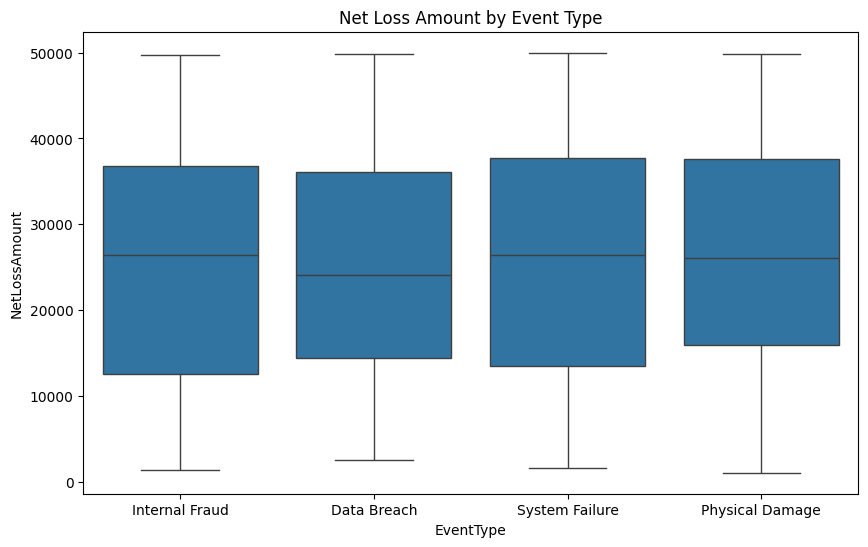

<Figure size 1200x600 with 0 Axes>

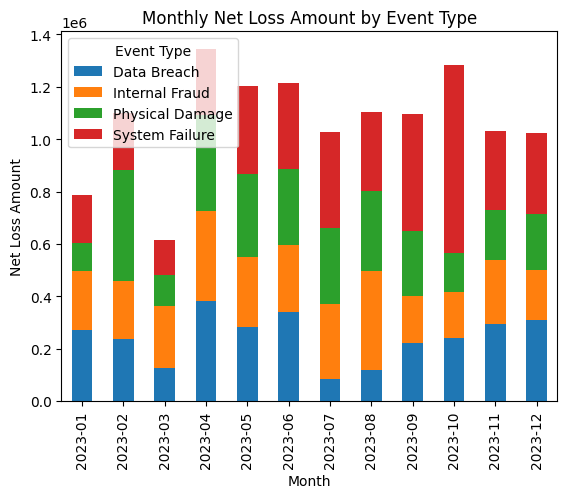

<Figure size 1200x600 with 0 Axes>

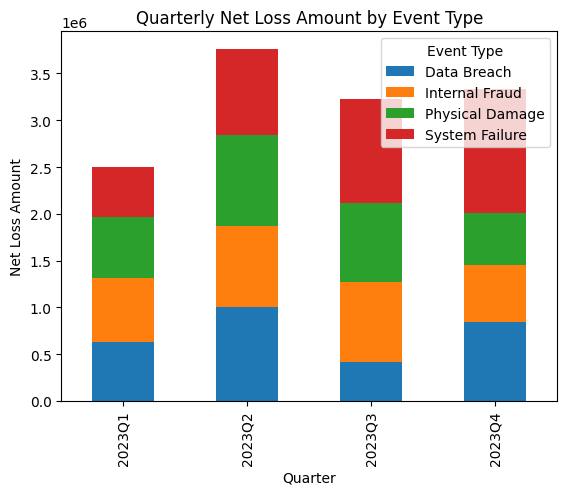

<Figure size 1200x600 with 0 Axes>

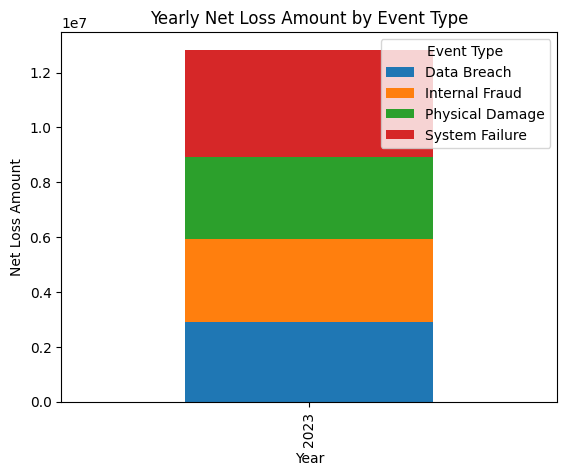


Topics in Event Descriptions:
Topic 1:
data center crash damage server
Topic 2:
theft asset employee detected access


ValueError: could not broadcast input array from shape (12,) into shape (21,)

<Figure size 1000x400 with 0 Axes>

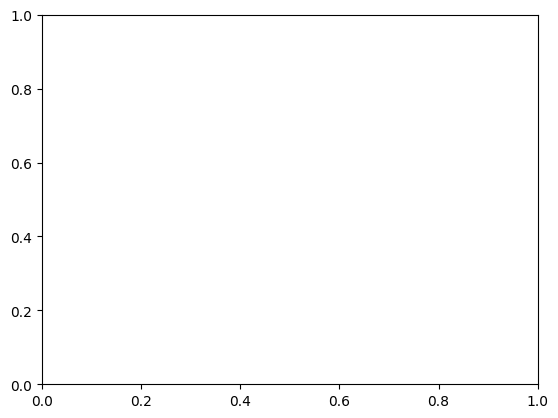

In [20]:
# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')

# Generate sample data
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
num_records = 500
df = pd.DataFrame({
    'Date': np.random.choice(dates, num_records),
    'EventID': np.arange(1, num_records + 1),
    'EventType': np.random.choice(['System Failure', 'Data Breach', 'Internal Fraud', 'Physical Damage'], num_records),
    'EventDescription': np.random.choice(['System crash in data center', 
                                          'Unauthorized access detected', 
                                          'Employee theft of assets', 
                                          'Server damage due to fire'], num_records),
    'NetLossAmount': np.random.randint(1000, 50000, num_records)
})

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Add Time Period columns
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year

# EDA: Outliers & Distribution of NetLossAmount by EventType
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='EventType', y='NetLossAmount')
plt.title('Net Loss Amount by Event Type')
plt.show()

# Aggregate by Event Type
event_type_monthly = df.groupby([df.index.to_period('M'), 'EventType'])['NetLossAmount'].sum().unstack(fill_value=0)
event_type_quarterly = df.groupby([df.index.to_period('Q'), 'EventType'])['NetLossAmount'].sum().unstack(fill_value=0)
event_type_yearly = df.groupby([df.index.to_period('Y'), 'EventType'])['NetLossAmount'].sum().unstack(fill_value=0)

# Monthly Distribution Plot
plt.figure(figsize=(12, 6))
event_type_monthly.plot(kind='bar', stacked=True)
plt.title('Monthly Net Loss Amount by Event Type')
plt.ylabel('Net Loss Amount')
plt.xlabel('Month')
plt.legend(title='Event Type')
plt.show()

# Quarterly Distribution Plot
plt.figure(figsize=(12, 6))
event_type_quarterly.plot(kind='bar', stacked=True)
plt.title('Quarterly Net Loss Amount by Event Type')
plt.ylabel('Net Loss Amount')
plt.xlabel('Quarter')
plt.legend(title='Event Type')
plt.show()

# Yearly Distribution Plot
plt.figure(figsize=(12, 6))
event_type_yearly.plot(kind='bar', stacked=True)
plt.title('Yearly Net Loss Amount by Event Type')
plt.ylabel('Net Loss Amount')
plt.xlabel('Year')
plt.legend(title='Event Type')
plt.show()

### NLP: Topic Modeling with LDA on Event Descriptions
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df['ProcessedDescription'] = df['EventDescription'].apply(preprocess_text)

# Topic modeling
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['ProcessedDescription'])
lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda.fit(dtm)

# Display topics
def display_topics(model, feature_names, n_top_words):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx + 1))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print("\nTopics in Event Descriptions:")
display_topics(lda, vectorizer.get_feature_names_out(), 5)

### Step 2: ACF and PACF for ARIMA Model Order Selection
# ACF and PACF plots for ARIMA
plt.figure(figsize=(10, 4))
plot_acf(event_type_monthly.sum(axis=1), lags=20)
plt.title('ACF Plot')
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(event_type_monthly.sum(axis=1), lags=20)
plt.title('PACF Plot')
plt.show()

### Step 3: Time Series Analysis with ARIMA, SARIMA, and SARIMAX Models
# Decomposition of Time Series
decomposition = seasonal_decompose(event_type_monthly.sum(axis=1), model='additive')
decomposition.plot()
plt.show()

# Automatic ARIMA model selection (non-seasonal)
arima_model = auto_arima(event_type_monthly.sum(axis=1), seasonal=False, trace=True)
arima_order = arima_model.order
print("ARIMA Order (p, d, q):", arima_order)

# Fit ARIMA model
arima_fitted = ARIMA(event_type_monthly.sum(axis=1), order=arima_order).fit()
print(arima_fitted.summary())

# Forecast with ARIMA
arima_forecast = arima_fitted.forecast(steps=12)
plt.figure(figsize=(10, 5))
plt.plot(event_type_monthly.sum(axis=1), label='Historical Data')
plt.plot(arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

# SARIMA Model (seasonal)
sarima_model = auto_arima(event_type_monthly.sum(axis=1), seasonal=True, m=12, trace=True)
sarima_order = sarima_model.order
sarima_seasonal_order = sarima_model.seasonal_order
print("SARIMA Order (p, d, q) and (P, D, Q, m):", sarima_order, sarima_seasonal_order)

# Fit SARIMA model
sarima_fitted = SARIMAX(event_type_monthly.sum(axis=1), order=sarima_order, seasonal_order=sarima_seasonal_order).fit()
print(sarima_fitted.summary())

# Forecast with SARIMA
sarima_forecast = sarima_fitted.forecast(steps=12)
plt.figure(figsize=(10, 5))
plt.plot(event_type_monthly.sum(axis=1), label='Historical Data')
plt.plot(sarima_forecast, label='SARIMA Forecast', linestyle='--')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

# SARIMAX Model: Adding Event Type Counts as Exogenous Variables
monthly_event_counts = df.groupby([df.index.to_period("M"), 'EventType']).size().unstack(fill_value=0)
sarimax_model = SARIMAX(event_type_monthly.sum(axis=1), order=sarima_order, seasonal_order=sarima_seasonal_order, exog=monthly_event_counts).fit()

# Forecast with SARIMAX
sarimax_forecast = sarimax_model.get_forecast(steps=12, exog=monthly_event_counts[-12:]).predicted_mean
plt.figure(figsize=(10, 5))
plt.plot(event_type_monthly.sum(axis=1), label='Historical Data')
plt.plot(sarimax_forecast, label='SARIMAX Forecast', linestyle='--')
plt.title('SARIMAX Forecast')
plt.legend()
plt.show()


In [21]:
!pip install jupyter_contrib_nbextensions
# jupyter contrib nbextension install --user

     ---------------------------------------- 0.0/23.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/23.5 MB ? eta -:--:--
     --------------------------------------- 0.0/23.5 MB 217.9 kB/s eta 0:01:48
     --------------------------------------- 0.1/23.5 MB 558.5 kB/s eta 0:00:42
      --------------------------------------- 0.4/23.5 MB 2.3 MB/s eta 0:00:10
     - -------------------------------------- 0.9/23.5 MB 4.2 MB/s eta 0:00:06
     -- ------------------------------------- 1.4/23.5 MB 5.8 MB/s eta 0:00:04
     --- ------------------------------------ 2.2/23.5 MB 7.8 MB/s eta 0:00:03
     ---- ----------------------------------- 2.9/23.5 MB 8.3 MB/s eta 0:00:03
     ------ --------------------------------- 3.5/23.5 MB 9.4 MB/s eta 0:00:03
     ------ --------------------------------- 4.1/23.5 MB 10.0 MB/s eta 0:00:02
     ------- -------------------------------- 4.7/23.5 MB 10.3 MB/s eta 0:00:02
     --------- ------------------------------ 5.4/23.5 MB 10.8


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy